<a href="https://colab.research.google.com/github/paulo-santos-ds/Python/blob/main/Previsao_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importando as bibliotecas necessárias

import numpy as np  # Álgebra linear
import pandas as pd  # Processamento de dados
import matplotlib.pyplot as plt  # Visualização de dados
import seaborn as sns  # Visualização de dados
from sklearn.metrics import mean_squared_error  # Métrica de erro quadrático médio
import datetime
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
# Configurando o estilo dos gráficos
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
# Carregando os dados de treino e teste
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
# Verificando os dados de treino
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [ ]:
# Convertendo a coluna de datas para o formato datetime
train_df.date = pd.to_datetime(train_df.date)
test_df.date = pd.to_datetime(test_df.date)

In [ ]:
# Extraindo informações de ano, mês, dia do mês e dia da semana das datas
train_df['year'] = train_df.date.dt.year
test_df['year'] = test_df.date.dt.year

In [ ]:
train_df['month'] = train_df.date.dt.month
test_df['month'] = test_df.date.dt.month


In [ ]:
train_df['dayofmonth'] = train_df.date.dt.day
test_df['dayofmonth'] = test_df.date.dt.day

In [ ]:
train_df['dayofweek'] = train_df.date.dt.dayofweek
test_df['dayofweek'] = test_df.date.dt.dayofweek

In [ ]:
train_df['dayname'] = train_df.date.dt.strftime('%A')
test_df['dayname'] = test_df.date.dt.strftime('%A')

In [ ]:
# Verificando o período dos dados
print('Train: ', min(train_df.date), max(train_df.date))
print('\n')
print('Test: ', min(test_df.date), max(test_df.date))

Train:  2013-01-01 00:00:00 2017-08-15 00:00:00


Test:  2017-08-16 00:00:00 2017-08-31 00:00:00


In [ ]:
# Verificando os tipos de produtos
train_df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

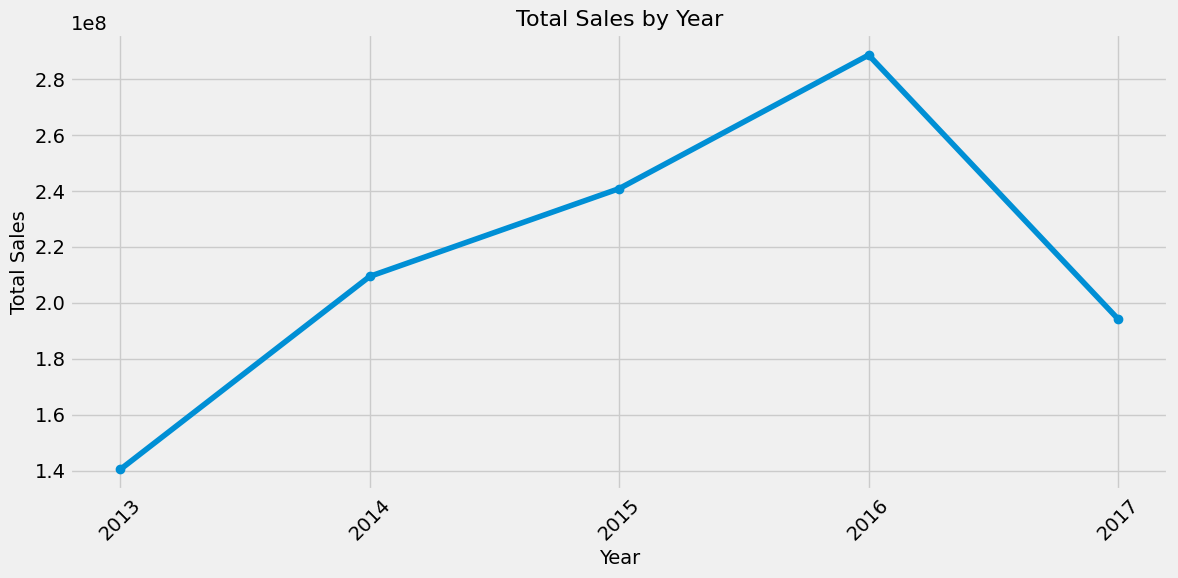

In [ ]:
# Visualizando a evolução das vendas
total_sales = train_df.groupby('year')['sales'].sum()
plt.figure(figsize=(12, 6))
plt.plot(total_sales.index, total_sales.values, marker='o', linestyle='-')

plt.title('Total Sales by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)

plt.xticks(total_sales.index, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

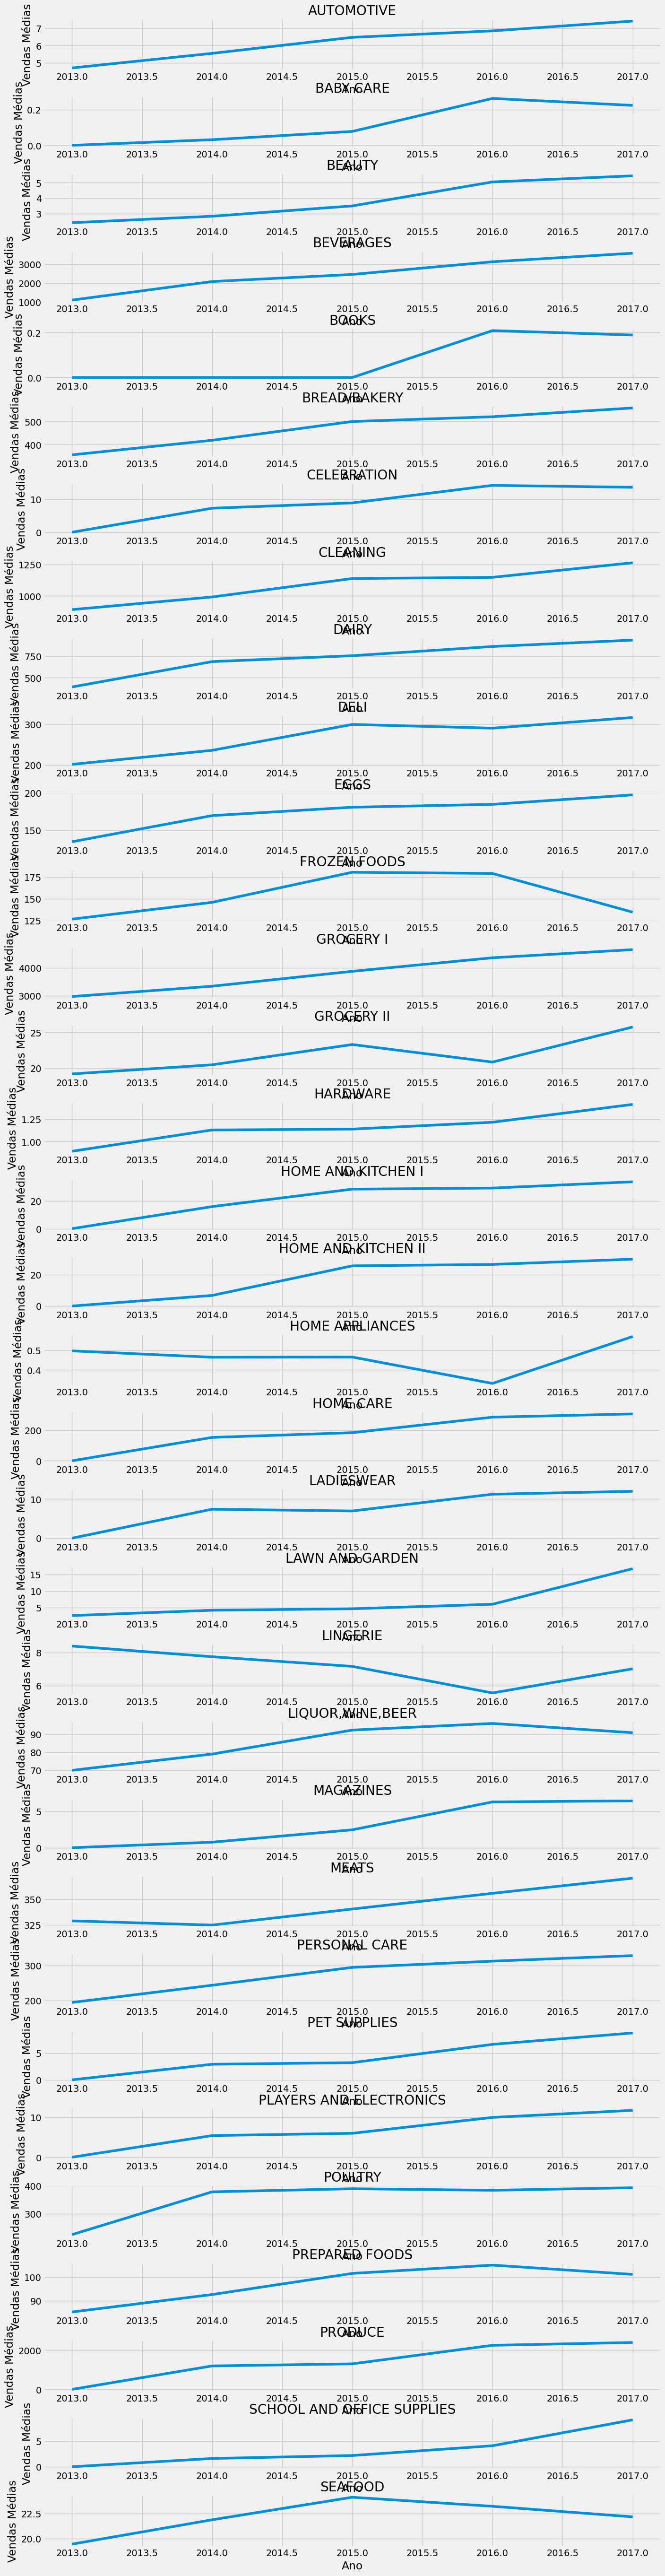

In [ ]:

# Definir o tamanho da figura com base no número de produtos
num_products = len(train_df.family.unique())
fig = plt.figure(figsize=(15, num_products * 2))
fig.subplots_adjust(hspace=0.5)

for i, product in enumerate(train_df.family.unique()):
    ax = fig.add_subplot(num_products, 1, i + 1)
    train_df.query('family == @product').groupby(['year']).sales.mean().plot(ax=ax)
    ax.set_title(product)
    ax.set_xlabel('Ano')
    ax.set_ylabel('Vendas Médias')

plt.show()


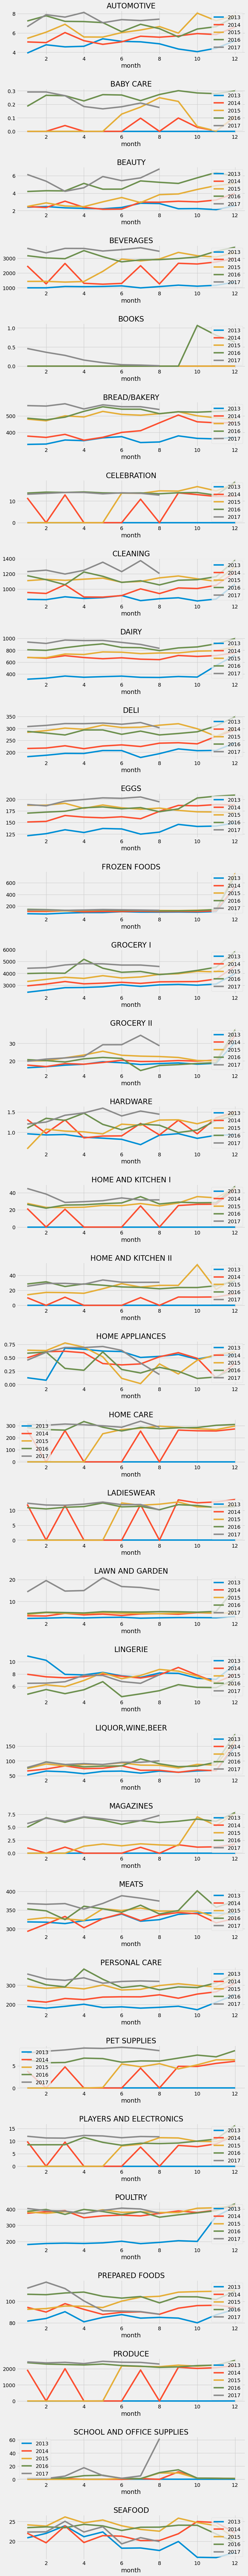

In [ ]:
# Visualizando a evolução das vendas mensais por produto e ano
fig = plt.figure(figsize=(10, 120))
fig.subplots_adjust(hspace=0.75)
for i, product in enumerate(train_df.family.unique()):
    ax = fig.add_subplot(33, 1, i + 1)
    select = train_df.query('family == @product')
    for year in [2013, 2014, 2015, 2016, 2017]:
        select.query('year == @year').groupby('month').sales.mean().plot(ax=ax, label=year)
    plt.title(product)
    ax.legend()

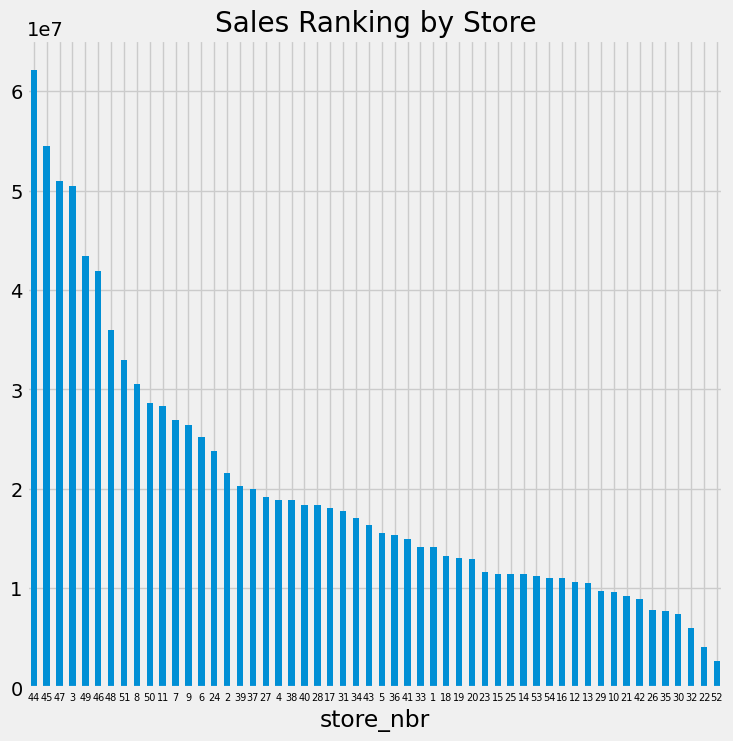

In [ ]:
# Observação: Alguns produtos têm vendas sazonais.

# Ranking de vendas por loja
plt.figure(figsize=(8, 8))
train_df.groupby('store_nbr').sales.sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Sales Ranking by Store')
# Ajustando a rotação dos rótulos do eixo x para 0 graus e diminuindo a fonte dos números
plt.xticks(rotation=0, fontsize=7)

plt.show()

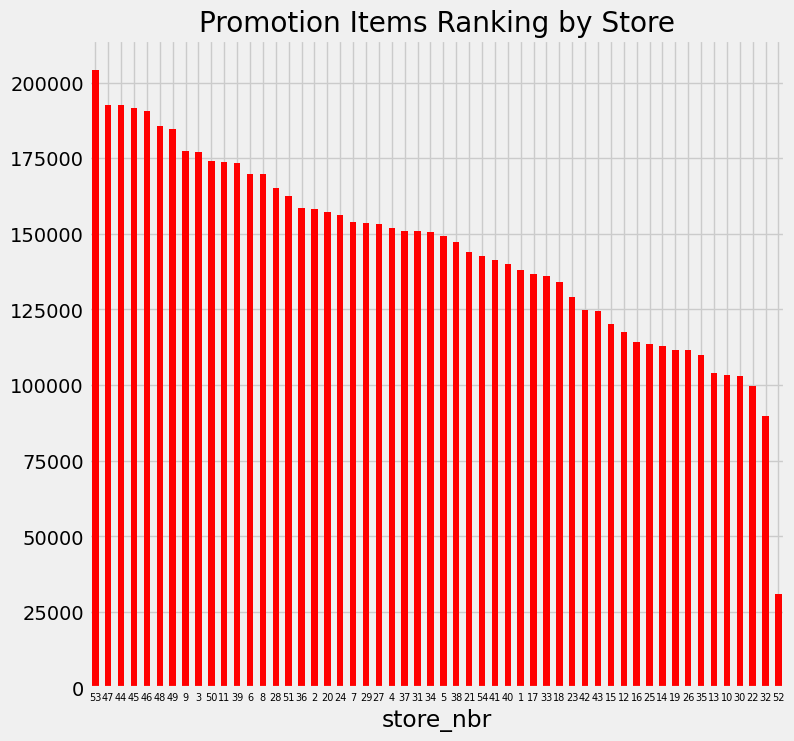

In [ ]:
# Ranking de vendas de itens promocionais por loja
plt.figure(figsize=(8, 8))
train_df.groupby('store_nbr').onpromotion.sum().sort_values(ascending=False).plot(kind='bar', color='red')
plt.title('Promotion Items Ranking by Store')

# Ajustando a rotação dos rótulos do eixo x para 0 graus e diminuindo a fonte dos números
plt.xticks(rotation=0, fontsize=7)

plt.show()


Text(0.5, 1.0, 'Promotion and Sales Relationship')

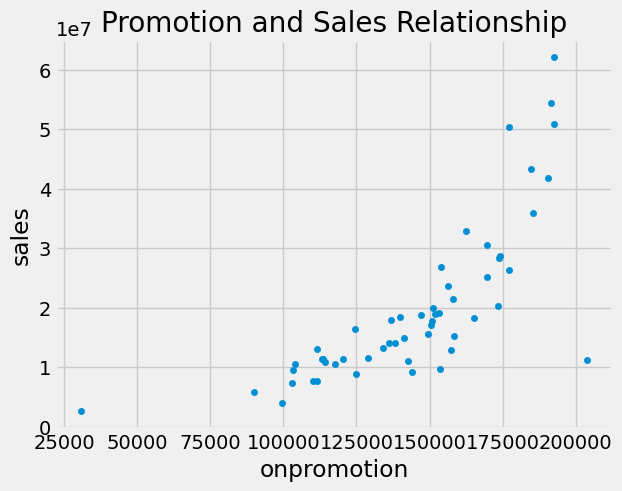

In [ ]:
# Observação: Há uma correlação positiva entre promoções e vendas, mas a loja 52 tem vendas extremamente baixas.

# Relação entre promoções e vendas
train_df.groupby('store_nbr')[['onpromotion', 'sales']].sum().plot.scatter('onpromotion', 'sales')
plt.title('Promotion and Sales Relationship')

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(-200.0, 0, '−200'),
  Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000'),
  Text(1200.0, 0, '1200'),
  Text(1400.0, 0, '1400')])

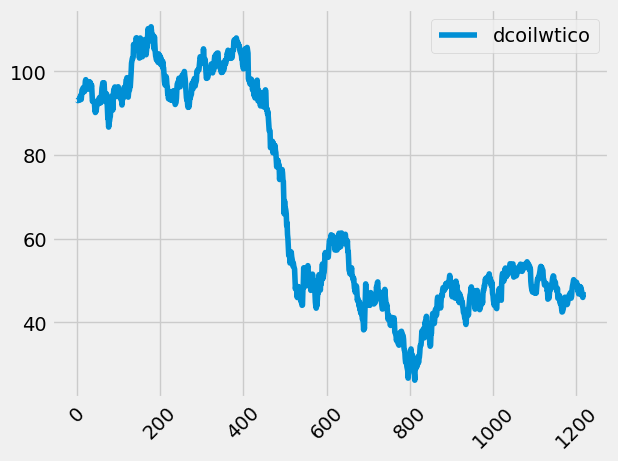

In [ ]:
# Observação: A correlação positiva entre promoções e vendas sugere que promoções podem ser uma característica importante.

# Análise dos preços do petróleo
# Observação: A economia do Equador está intimamente ligada aos preços do petróleo.
oil = pd.read_csv('/content/oil.csv')
oil = oil.interpolate(method='linear')
oil.iloc[0] = oil.iloc[1]
oil.plot()
plt.xticks(rotation=45)


In [ ]:
# Observação: Os preços do petróleo estão em tendência de queda.

start_date = train_df.date.min()
number_of_days = 1704
date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

date = (pd.Series(date_list)).to_frame()
date.columns = ['date']
date.date = pd.to_datetime(date.date)
date['date_str'] = date.date.astype(str)
oil['date_str'] = oil.index.astype(str)

oil = pd.merge(date,oil,how='left',on='date_str')

In [ ]:
# Verificando as colunas do DataFrame
print(train_df.columns)

# Se a coluna 'dcoilwtico' não estiver presente, verifique o nome correto
# Supondo que a coluna correta seja 'oil_price', por exemplo
if 'dcoilwtico' not in train_df.columns:
    print("Coluna 'dcoilwtico' não encontrada. Verifique o nome da coluna.")
else:
    # Seu código para trabalhar com a coluna 'dcoilwtico'
    oil_prices = train_df['dcoilwtico']
    # Continue com a análise ou visualização

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'dayofmonth', 'dayofweek', 'dayname'],
      dtype='object')
Coluna 'dcoilwtico' não encontrada. Verifique o nome da coluna.


In [ ]:
oil['date_str'] = oil.index.astype(str)

In [ ]:
train_df['date_str'] = train_df.date.astype(str)

train_df = pd.merge(train_df,oil,how='left',on='date_str')
train_df.drop(columns='date_str',axis=1,inplace=True)

In [ ]:
test_df['date_str'] = test_df.date.astype(str)
test_df = pd.merge(test_df,oil,how='left', on='date_str')

test_df.drop(columns='date_str',axis=1,inplace=True)

In [ ]:
unique_families = train_df['family'].unique()
for family in unique_families:
    family_data = train_df[train_df['family'] == family]
    print(family, family_data[['dcoilwtico', 'sales']].head())  # Verifique os primeiros 5 registros

print(train_df[['dcoilwtico', 'sales']].describe())


AUTOMOTIVE      dcoilwtico  sales
0           NaN    0.0
33          NaN    0.0
66          NaN    0.0
99          NaN    0.0
132         NaN    0.0
BABY CARE      dcoilwtico  sales
1           NaN    0.0
34          NaN    0.0
67          NaN    0.0
100         NaN    0.0
133         NaN    0.0
BEAUTY      dcoilwtico  sales
2           NaN    0.0
35          NaN    0.0
68          NaN    0.0
101         NaN    0.0
134         NaN    0.0
BEVERAGES      dcoilwtico  sales
3           NaN    0.0
36          NaN    0.0
69          NaN    0.0
102         NaN    0.0
135         NaN    0.0
BOOKS      dcoilwtico  sales
4           NaN    0.0
37          NaN    0.0
70          NaN    0.0
103         NaN    0.0
136         NaN    0.0
BREAD/BAKERY      dcoilwtico  sales
5           NaN    0.0
38          NaN    0.0
71          NaN    0.0
104         NaN    0.0
137         NaN    0.0
CELEBRATION      dcoilwtico  sales
6           NaN    0.0
39          NaN    0.0
72          NaN    0.0
105        

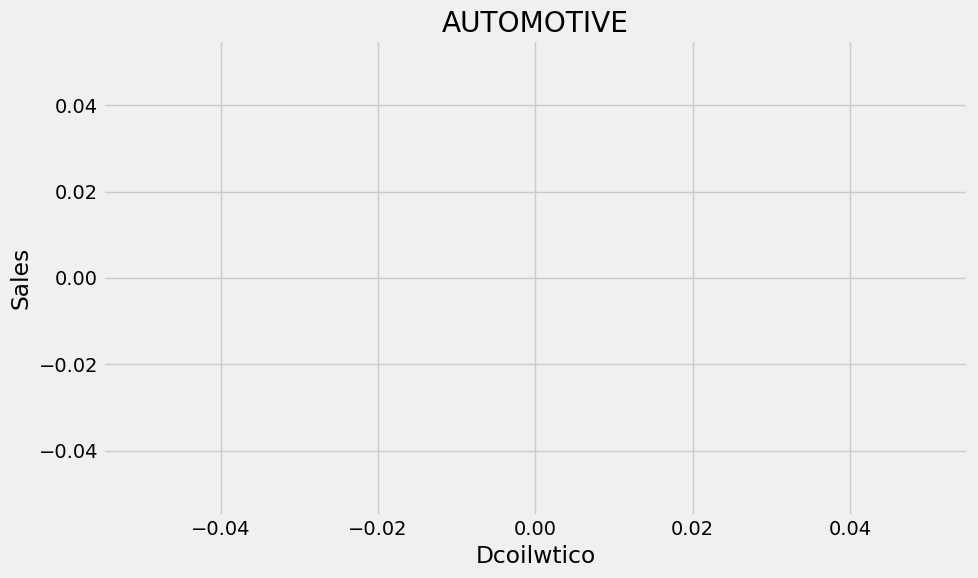

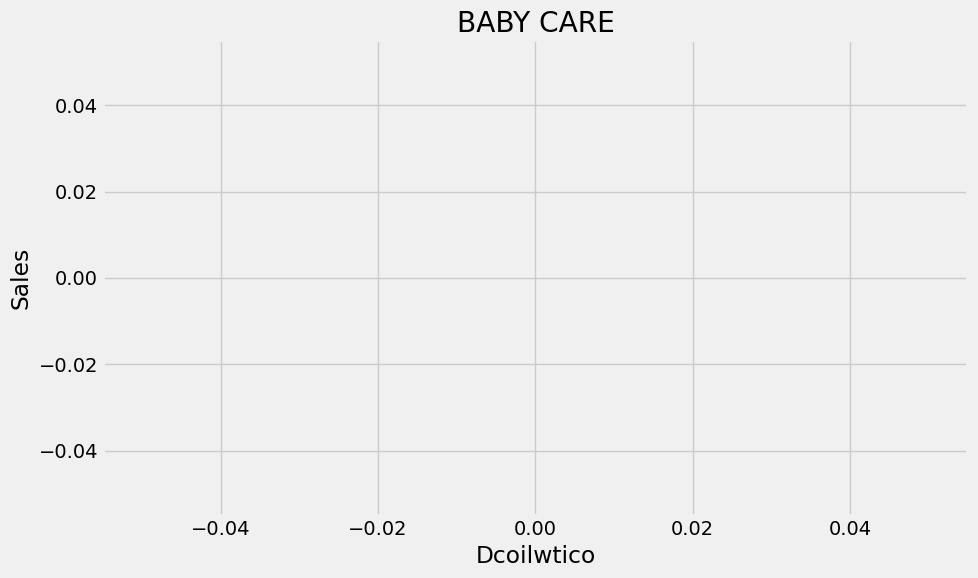

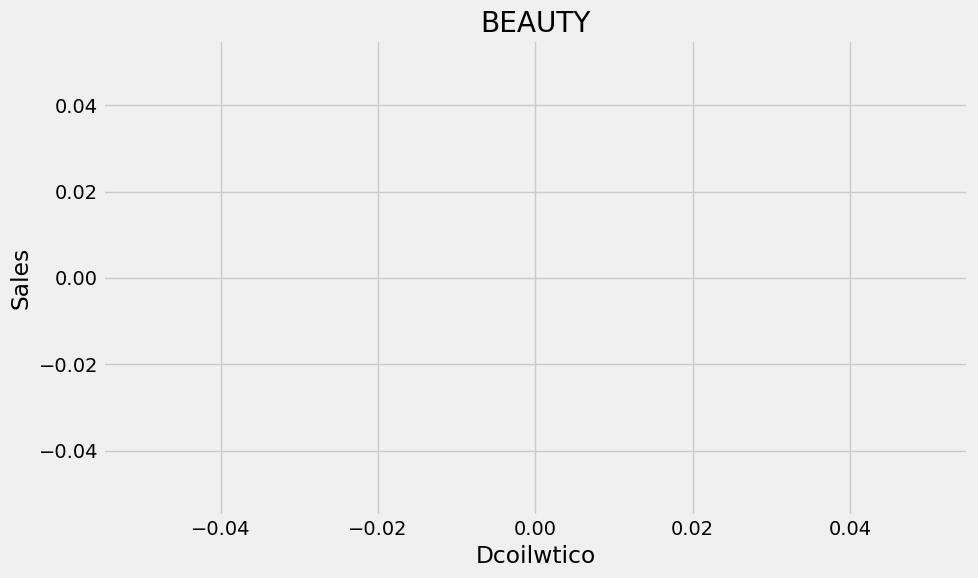

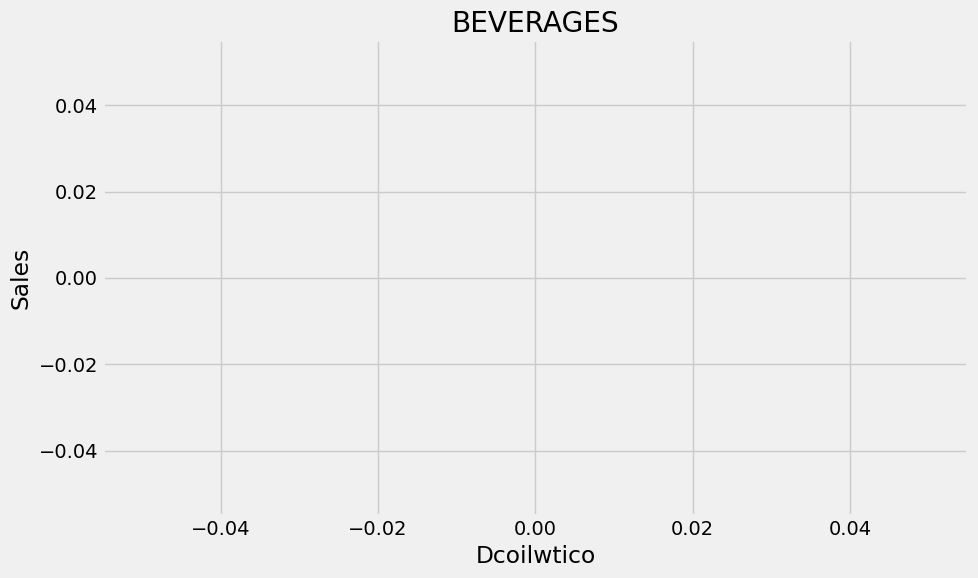

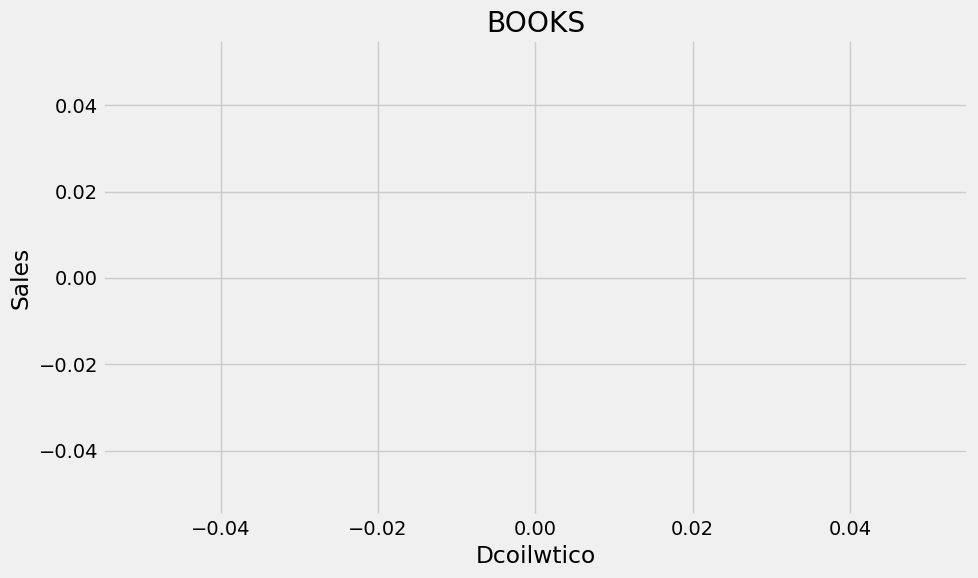

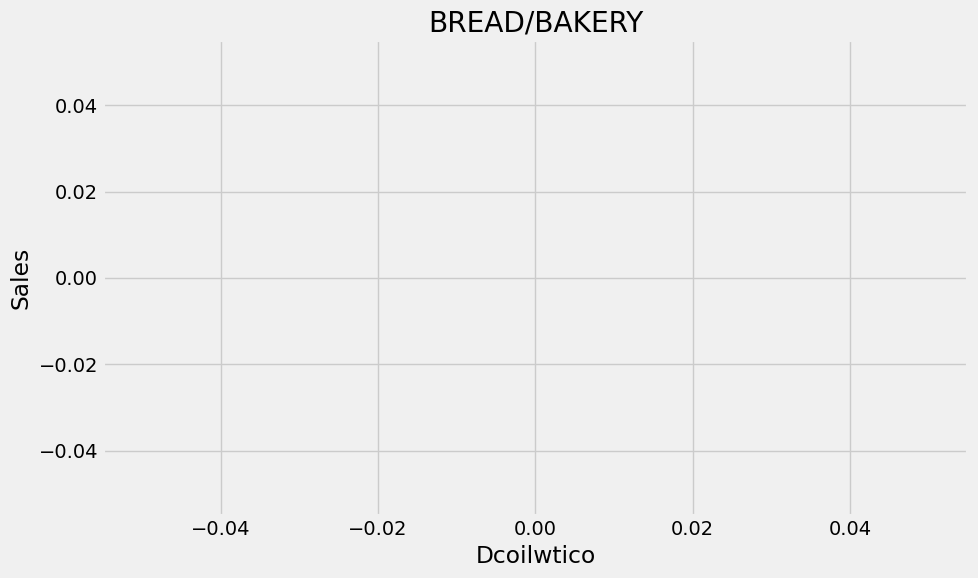

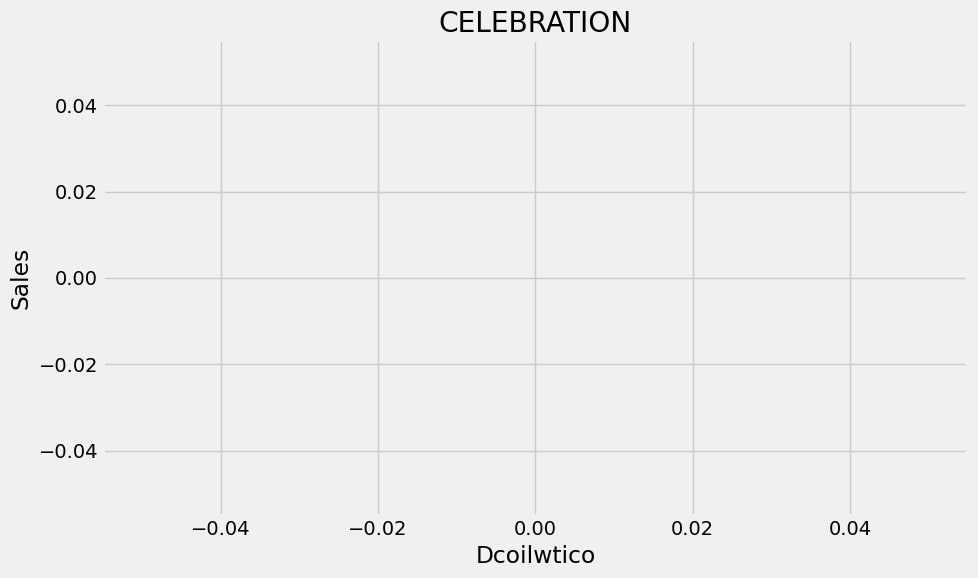

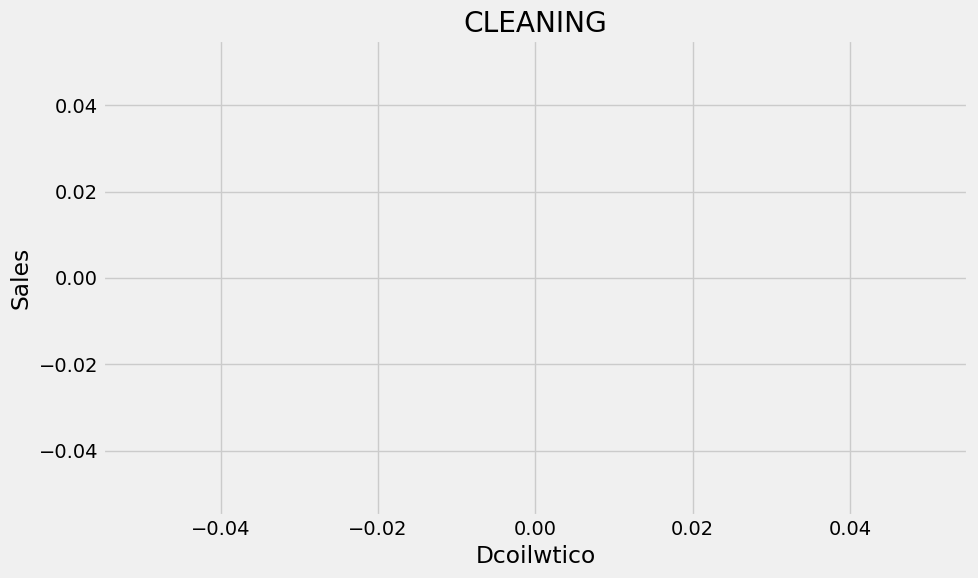

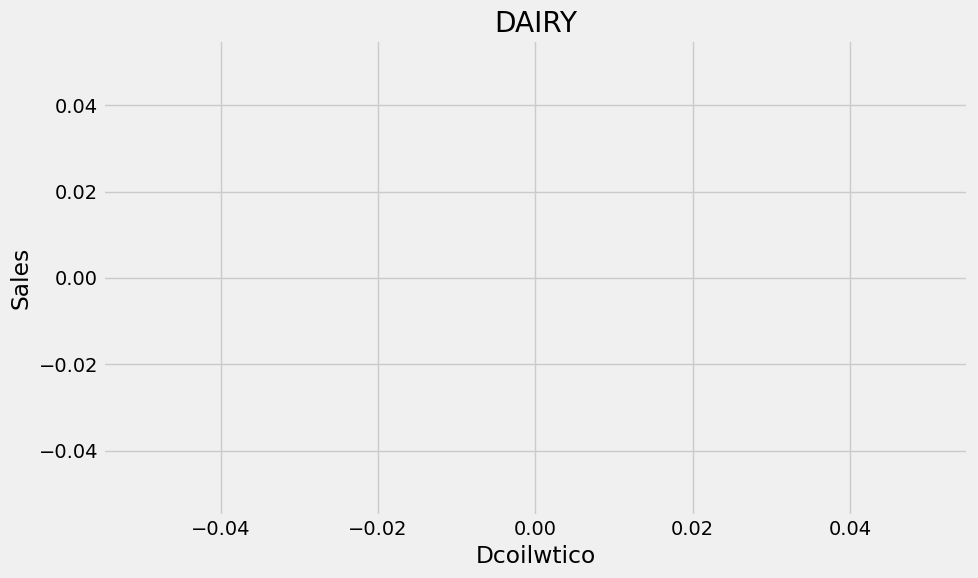

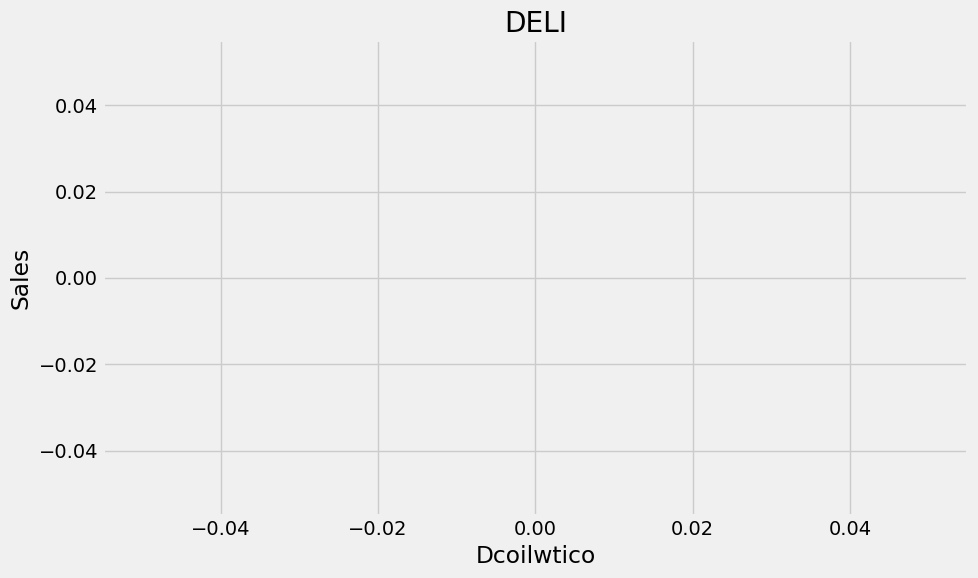

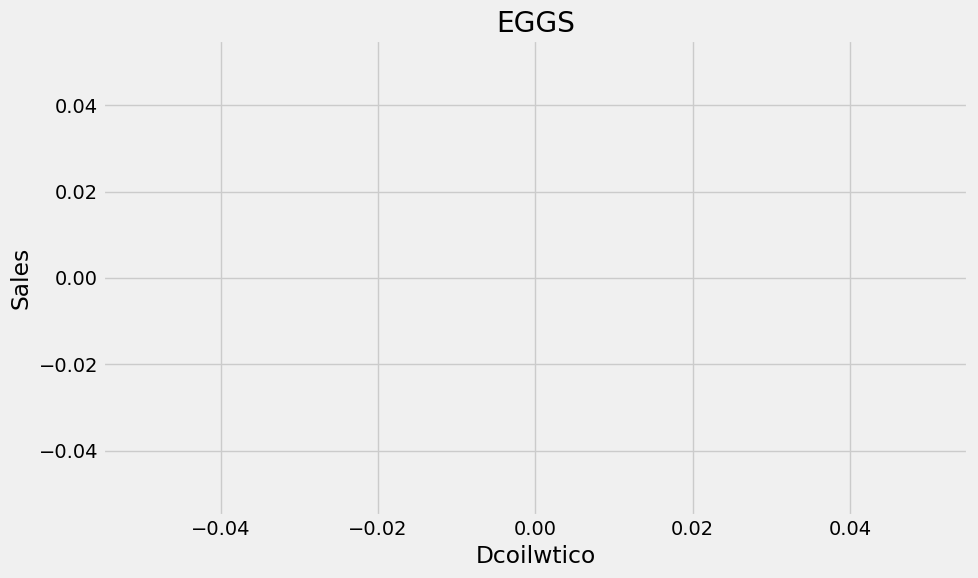

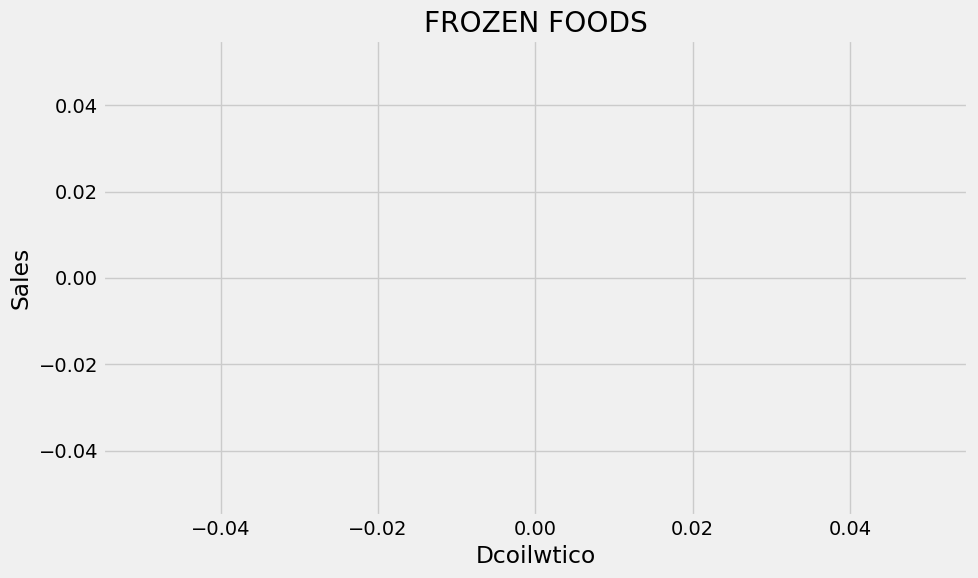

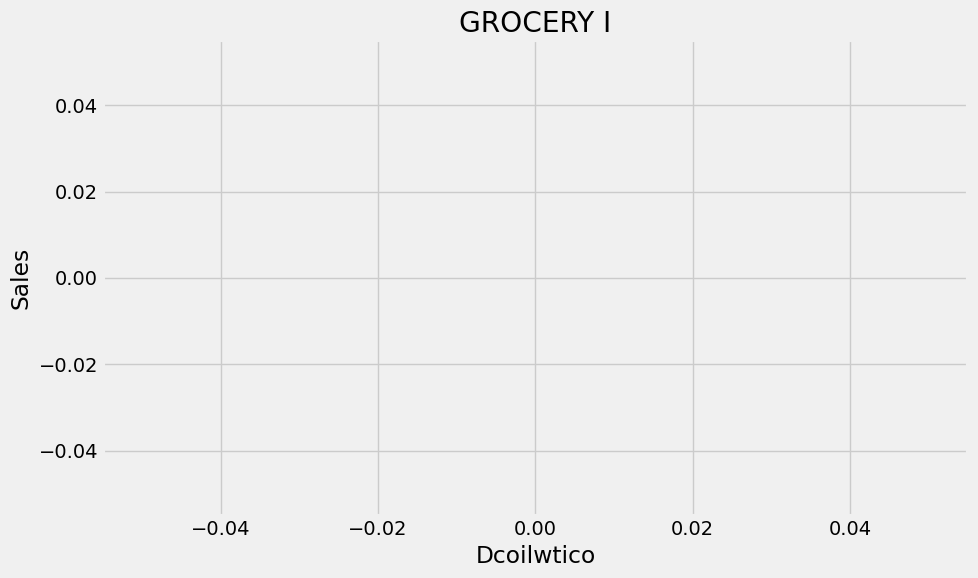

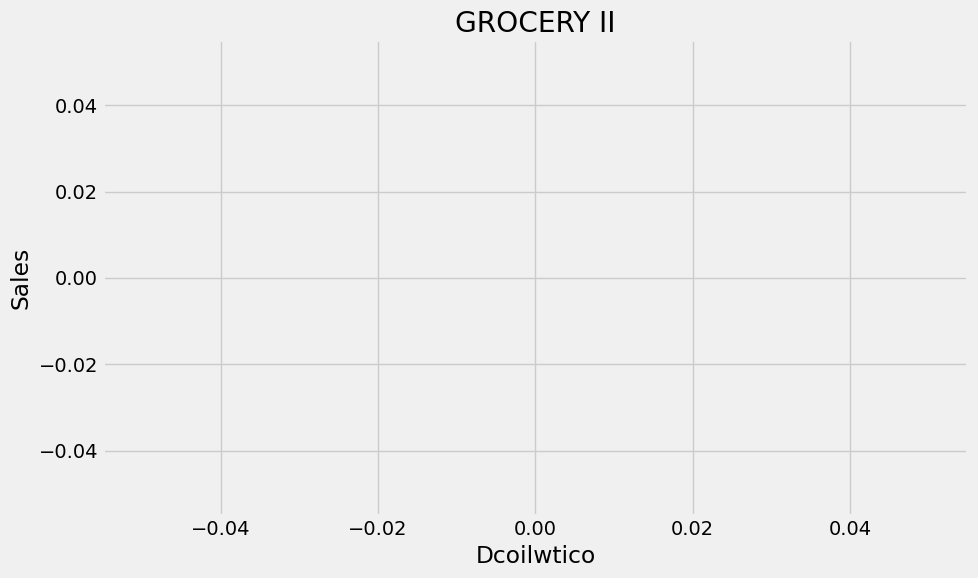

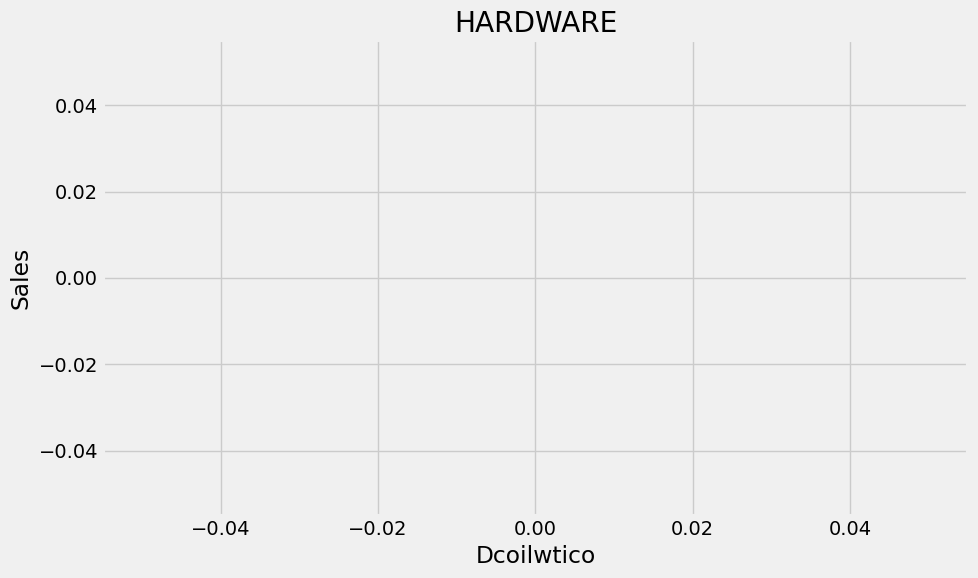

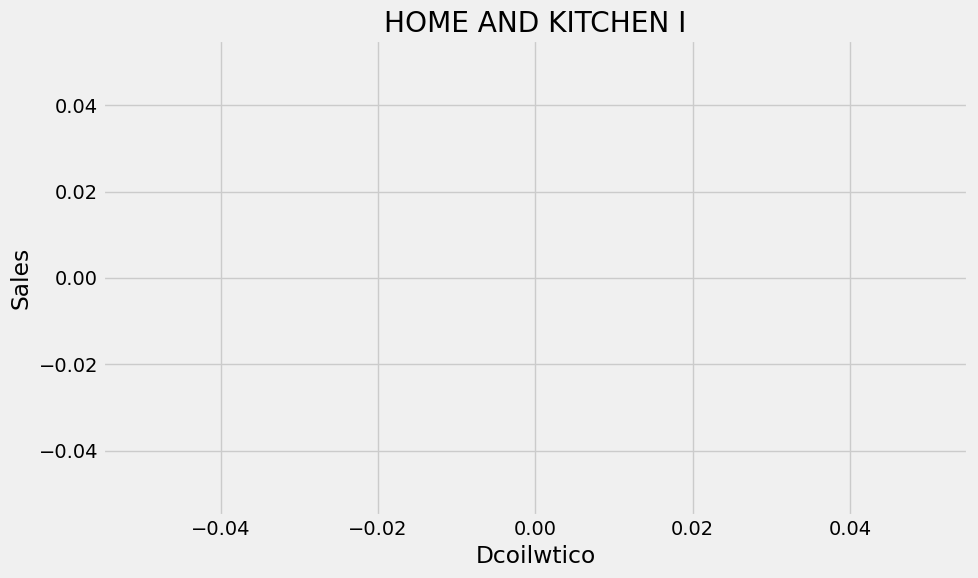

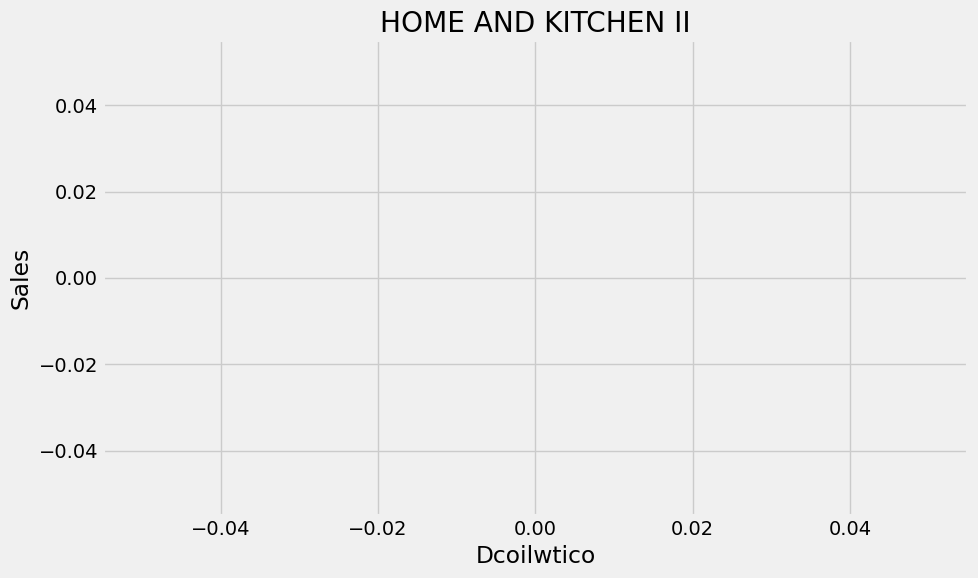

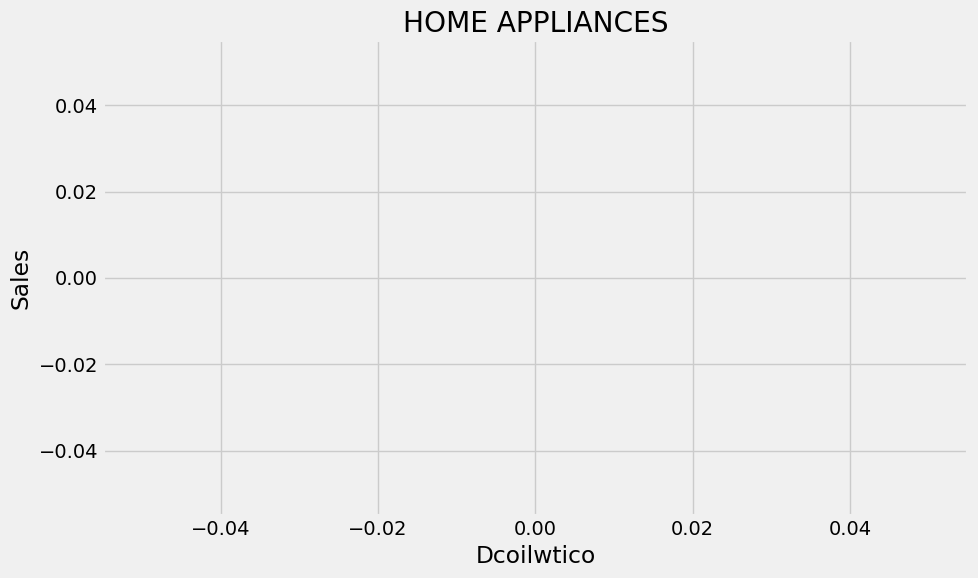

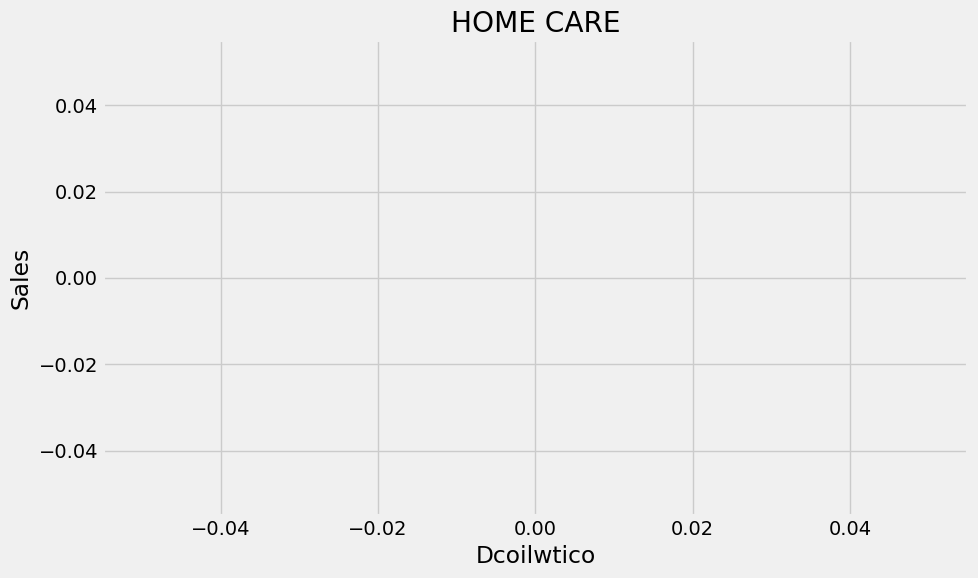

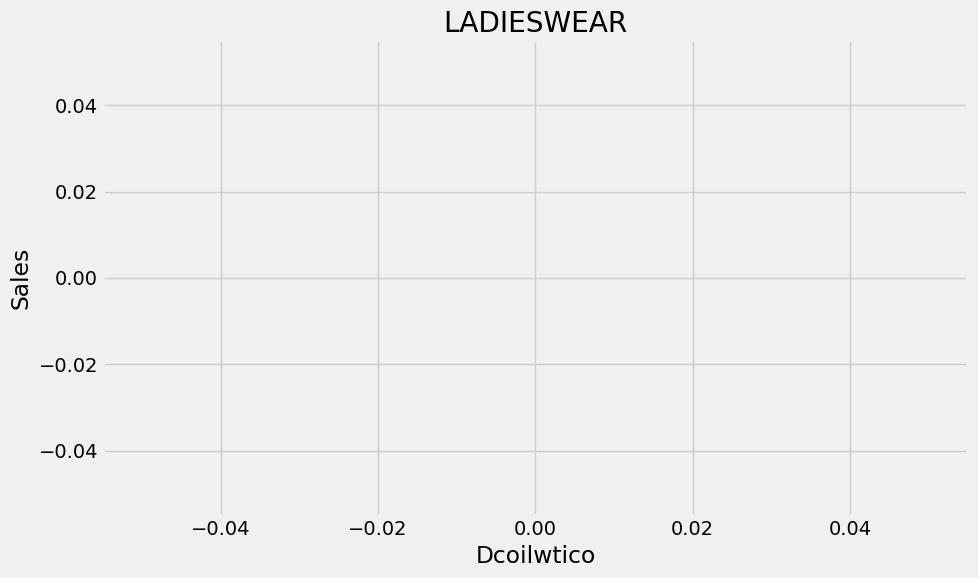

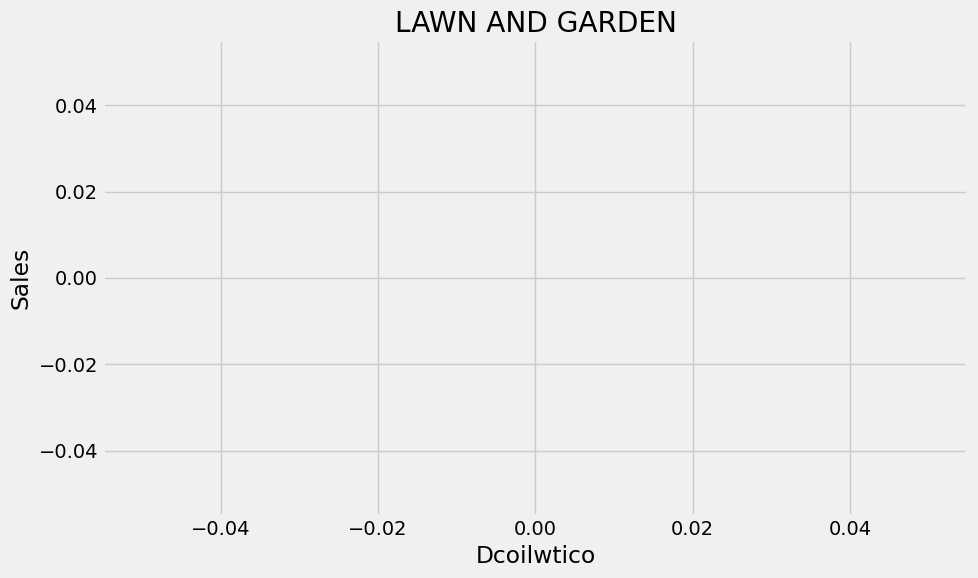

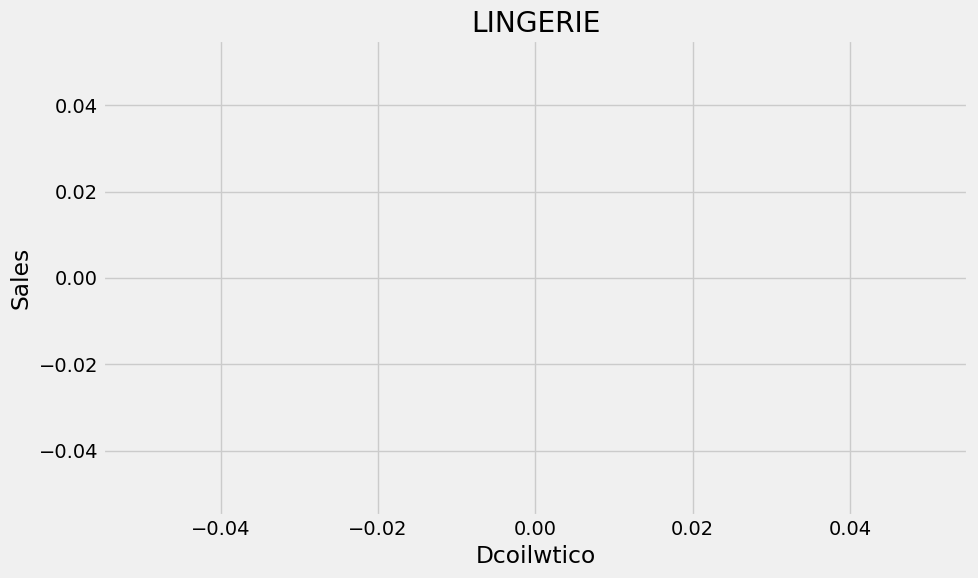

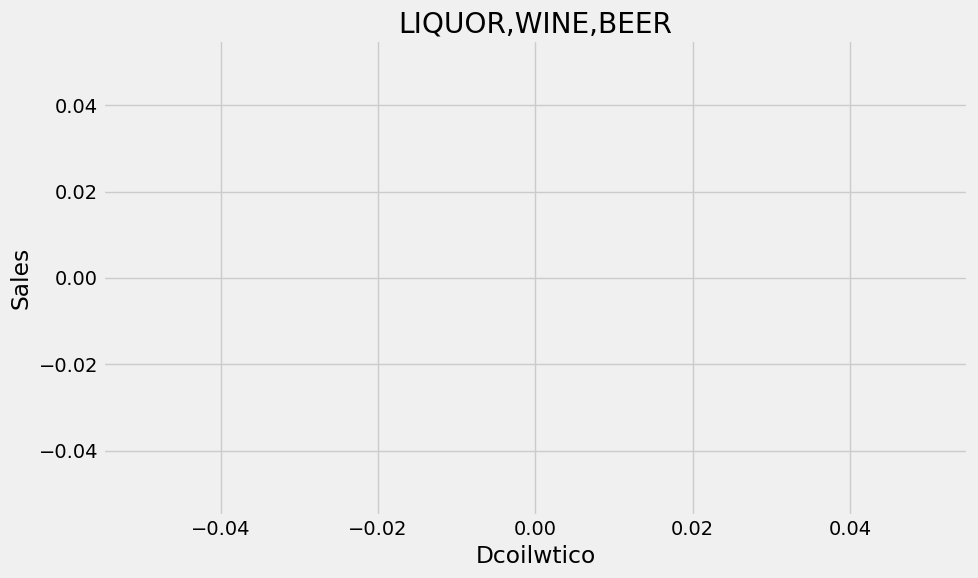

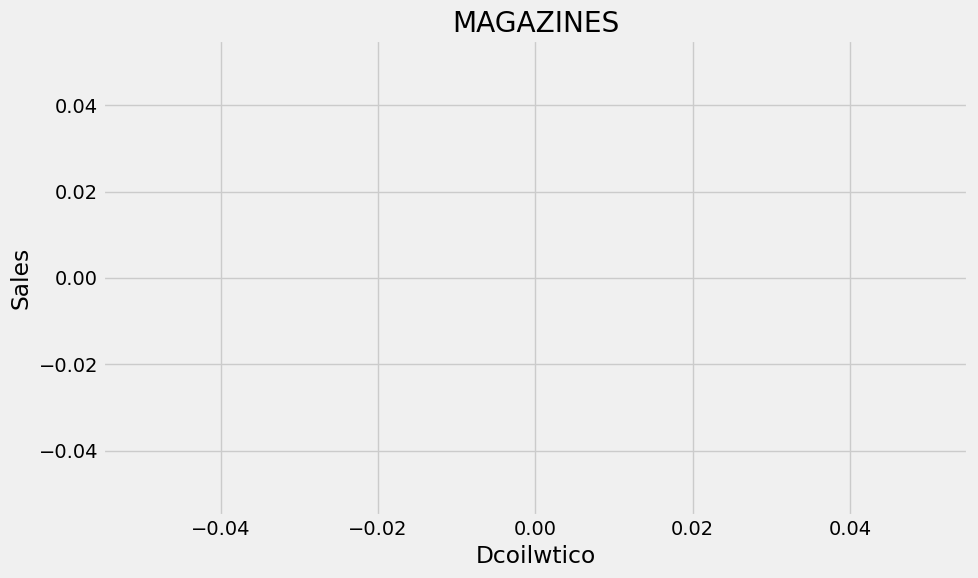

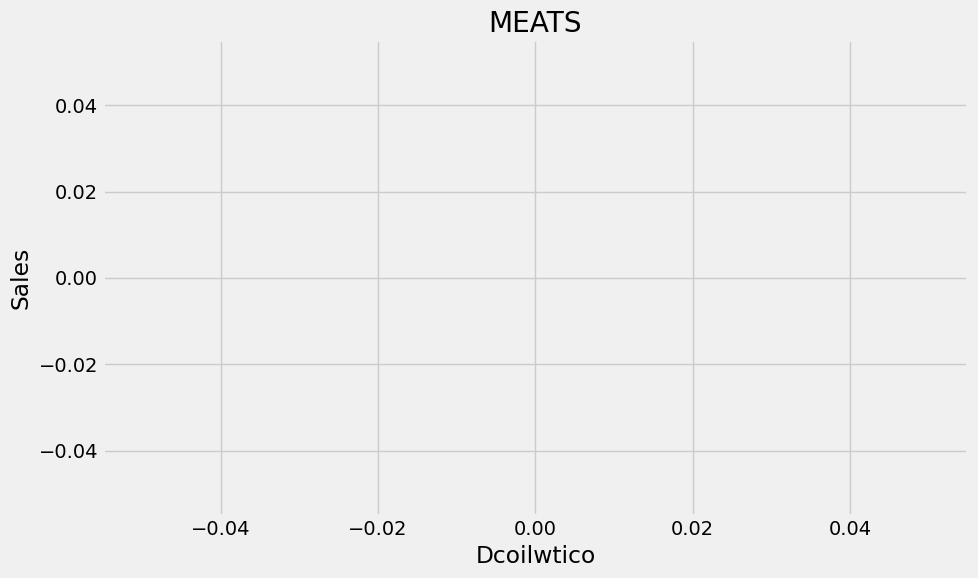

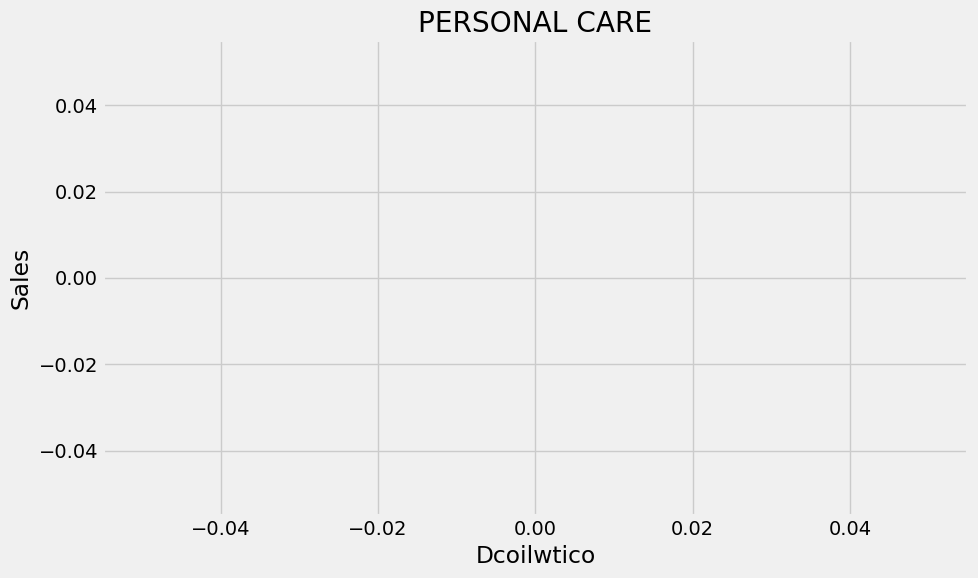

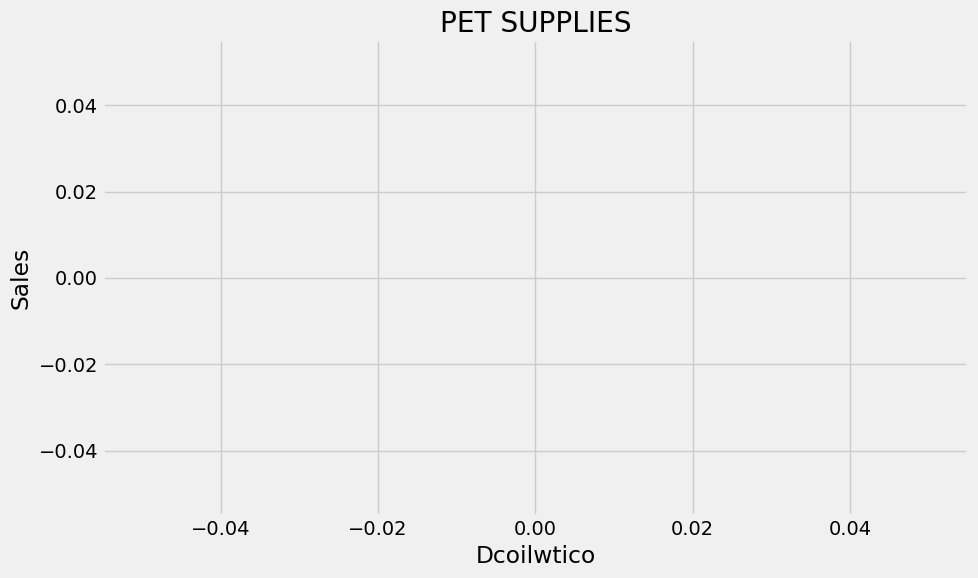

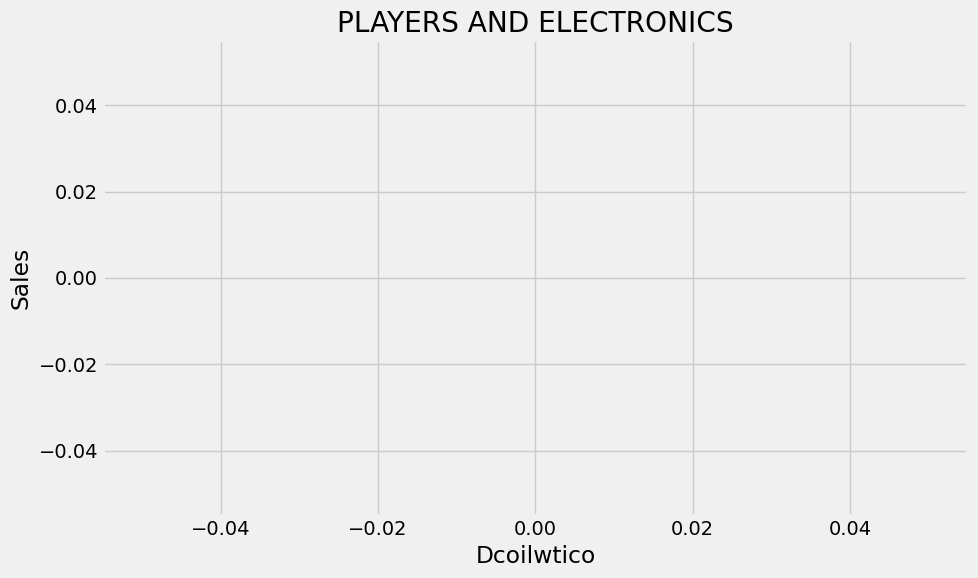

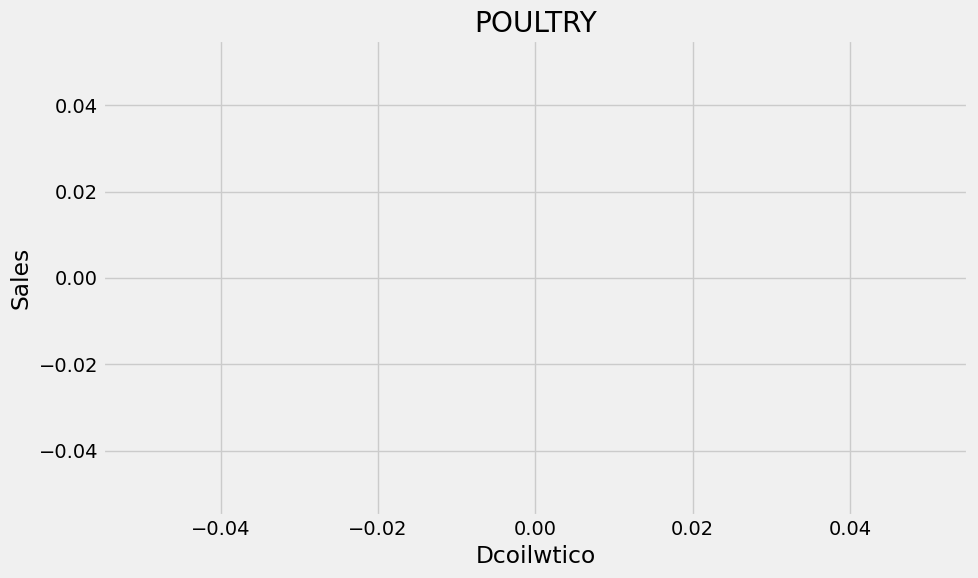

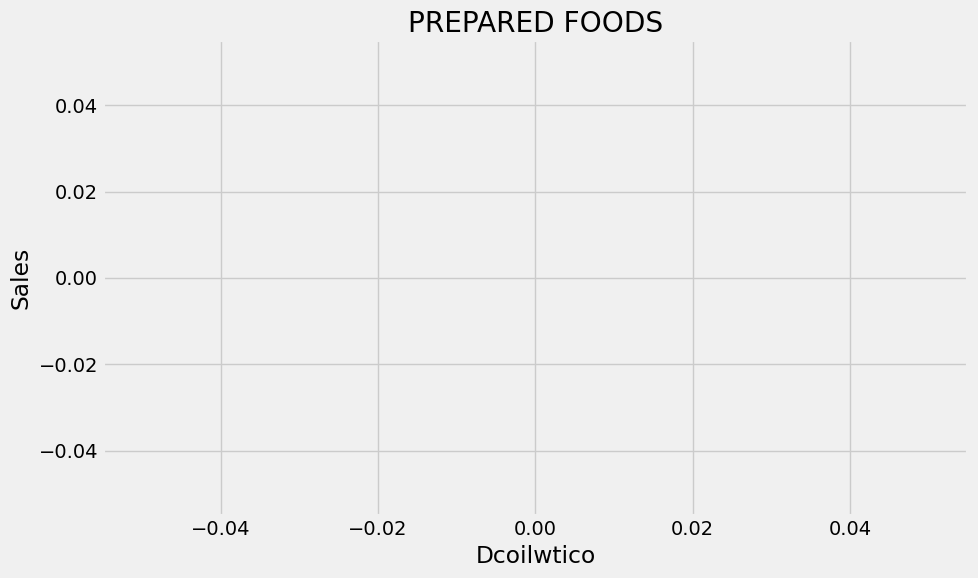

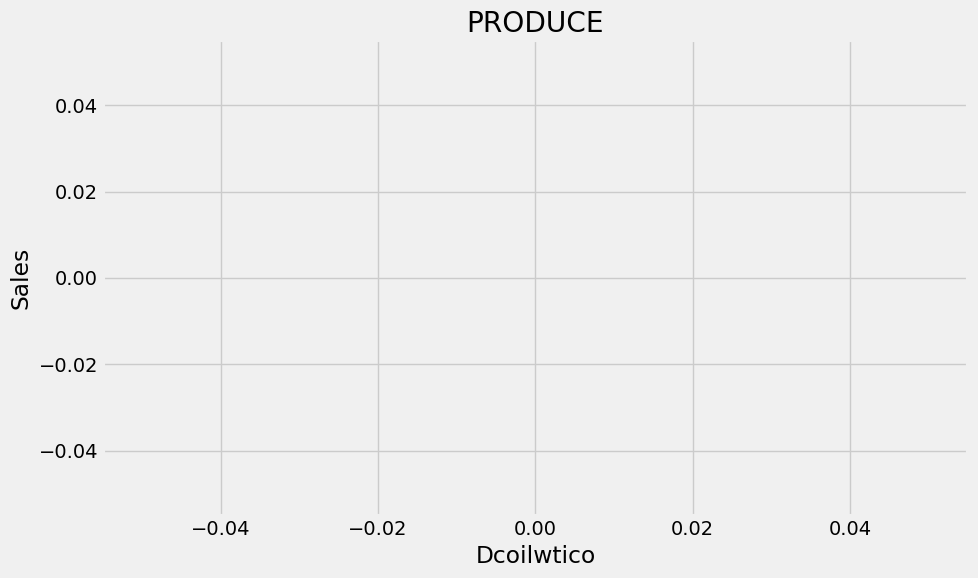

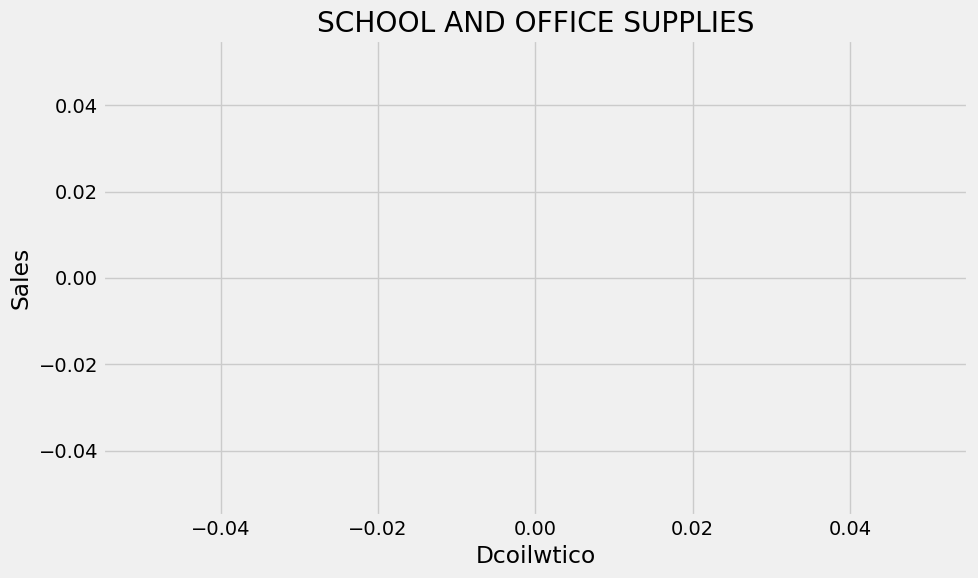

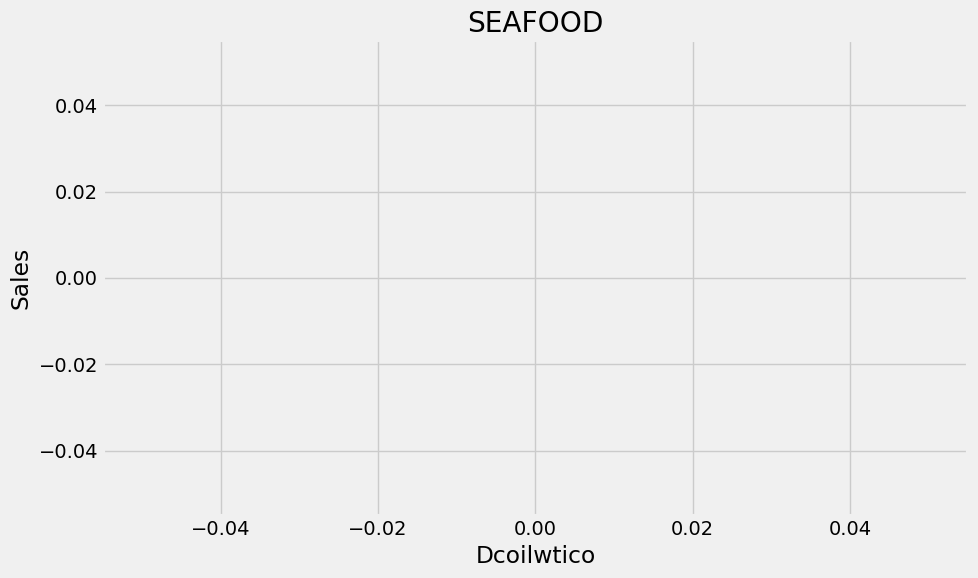

In [ ]:
unique_families = train_df['family'].unique()

# Loop sobre cada família
for family in unique_families:
    family_data = train_df[train_df['family'] == family]
    if family_data.empty:
        print(f"No data for family: {family}")
    else:
        plt.figure(figsize=(10, 6))
        plt.scatter(family_data['dcoilwtico'], family_data['sales'], alpha=0.5)
        plt.title(family)
        plt.xlabel('Dcoilwtico')
        plt.ylabel('Sales')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
stores = pd.read_csv('/content/stores.csv')
train_df = pd.merge(train_df,stores,how='left',on='store_nbr')
test_df = pd.merge(test_df,stores,how='left',on='store_nbr')

In [ ]:
start_date = train_df.date.min()
number_of_days = 1704
date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

date = (pd.Series(date_list)).to_frame()
date.columns = ['date']
date.date = pd.to_datetime(date.date)
date['date_str'] = date.date.astype(str)
oil['date_str'] = oil.index.astype(str)

oil = pd.merge(date,oil,how='left',on='date_str')

In [ ]:
oil = oil.set_index('date').dcoilwtico.interpolate(method='linear').to_frame()

In [ ]:
oil['date_str'] = oil.index.astype(str)

In [ ]:
# Convertendo a coluna 'date_str' para datetime no DataFrame train_df
train_df['date_str'] = pd.to_datetime(train_df.date.astype(str))

# Convertendo o índice do DataFrame oil para datetime
oil.index = pd.to_datetime(oil.index)

# Realizando o merge e adicionando sufixos para colunas duplicadas
train_df = pd.merge(train_df, oil, how='left', left_on='date_str', right_index=True, suffixes=('', '_oil'))

# Removendo a coluna de string de data
train_df.drop(columns='date_str', axis=1, inplace=True)



In [ ]:
# Convertendo a coluna 'date_str' para datetime no DataFrame test_df
test_df['date_str'] = pd.to_datetime(test_df.date.astype(str))

# Convertendo o índice do DataFrame oil para datetime
oil.index = pd.to_datetime(oil.index)

# Realizando o merge e adicionando sufixos para colunas duplicadas, se necessário
test_df = pd.merge(test_df, oil, how='left', left_on='date_str', right_index=True, suffixes=('', '_oil'))

# Removendo a coluna de string de data
test_df.drop(columns='date_str', axis=1, inplace=True)




In [ ]:
# Remover colunas de data originais
train_df = train_df.drop(columns=['date', 'date_x', 'date_y', 'date_str_oil'])

In [ ]:
# Converter colunas categóricas para numéricas usando one-hot encoding
train_df_encoded = pd.get_dummies(train_df, columns=['city', 'state', 'dayname'])

In [ ]:
# Definir características e alvo
from sklearn.model_selection import train_test_split

# Definir características e alvo
FEATURES = [col for col in train_df_encoded.columns if col != 'sales']
X = train_df_encoded[FEATURES]
y = train_df_encoded['sales']



In [ ]:
# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Criar imputadores para colunas numéricas e categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Criar um ColumnTransformer para aplicar as transformações necessárias
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Aplicar as transformações aos dados de treinamento e validação
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

# Verificar as formas dos conjuntos de dados após a imputação e transformação
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['dcoilwtico' 'dcoilwtico_oil']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['dcoilwtico' 'dcoilwtico_oil']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


X_train shape: (2400710, 42)
X_val shape: (600178, 42)


In [ ]:

from xgboost import XGBRegressor


# Definir características e alvo
FEATURES = [col for col in train_df_encoded.columns if col != 'sales']
X = train_df_encoded[FEATURES]
y = train_df_encoded['sales']

# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar colunas numéricas e categóricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Criar imputadores para colunas numéricas e categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Criar um ColumnTransformer para aplicar as transformações necessárias
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Aplicar as transformações aos dados de treinamento e validação
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

# Verificar as formas dos conjuntos de dados após a imputação e transformação
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

# Inicializar e treinar o modelo XGBoost
xgb = XGBRegressor(tree_method='hist', n_estimators=500, early_stopping_rounds=10)
xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['dcoilwtico' 'dcoilwtico_oil']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['dcoilwtico' 'dcoilwtico_oil']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


X_train shape: (2400710, 42)
X_val shape: (600178, 42)


KeyboardInterrupt: 

In [ ]:
# Fazer previsões
predictions = xgb.predict(X_val)
predictions = [a if a > 0 else 0 for a in predictions]

# Calcular e imprimir o MSLE
print('MSLE: ', mean_squared_log_error(y_val, predictions))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Converter colunas categóricas para numéricas usando one-hot encoding
train_df_encoded = pd.get_dummies(train_df, columns=['city', 'state', 'dayname'])

# Definir características e alvo
FEATURES = [col for col in train_df_encoded.columns if col != 'sales']
X = train_df_encoded[FEATURES]
y = train_df_encoded['sales']

# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preencher valores ausentes com a média
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

# Inicializar e treinar o modelo de regressão linear
linear = LinearRegression()
model = linear.fit(X_train, y_train)

# Avaliar o modelo
print(f"Score do modelo: {model.score(X_val, y_val)}")



In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor

# Supondo que 'train_df' seja seu DataFrame e 'FEATURES' seja uma lista de nomes de colunas de características

# Converter colunas categóricas para numéricas usando one-hot encoding
train_df_encoded = pd.get_dummies(train_df, columns=['city', 'state', 'dayname'])

# Definir características e alvo
FEATURES = [col for col in train_df_encoded.columns if col != 'sales']
X = train_df_encoded[FEATURES]
y = train_df_encoded['sales']

# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste de Hiperparâmetros usando Grid Search
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBRegressor(tree_method='hist', early_stopping_rounds=10)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_log_error', verbose=1)
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado pelo Grid Search
best_xgb = grid_search.best_estimator_

# Fazer previsões
predictions = best_xgb.predict(X_val)
predictions = [a if a > 0 else 0 for a in predictions]

# Calcular e imprimir o MSLE
print('Melhores Hiperparâmetros: ', grid_search.best_params_)
print('MSLE: ', mean_squared_log_error(y_val, predictions))


In [ ]:
predictions = xgb.predict(X_val)
predictions = [a if a > 0 else 0 for a in predictions]

# Calcular resíduos
residuals = y_val - predictions

# Criar gráfico de resíduos
plt.figure(figsize=(10, 6))
plt.scatter(X_val[:, 0], residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MSFT Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()



# Calcular e imprimir o MSLE
print('MSLE: ', mean_squared_log_error(y_val, predictions))


